imports

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Check data

In [11]:
data = pd.read_csv('./data/clean_data.csv')

In [12]:
data.dropna(subset=['dob'], inplace=True)

data['c_jail_in'] = pd.to_datetime(data['c_jail_in'], format='%d/%m/%Y %H:%M', dayfirst=True)
data['c_jail_out'] = pd.to_datetime(data['c_jail_out'], format='%d/%m/%Y %H:%M', dayfirst=True)
data['dob'] = pd.to_datetime(data['dob'], format='%d/%m/%Y', dayfirst=True)
data['duration'] = abs((data['c_jail_out'] - data['c_jail_in']).dt.days) + 1
data['duration'] = data['duration'].fillna(0)
data['duration'] = data['duration'].astype('int')
df = data[data['is_recid'] != -1]
df_glob = df.drop(['id', 'sex', 'race', 'c_charge_desc', 'c_charge_degree','first','last', 'age_cat', 'c_jail_in', 'c_jail_out', 'age', 'dob', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest', 'c_days_from_compas', 'r_offense_date', 'r_charge_desc', 'r_jail_in','vr_offense_date','vr_charge_desc','score_text','screening_date','v_decile_score','v_score_text','priors_count.1', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree'], axis=1) 
print(df_glob.columns)

Index(['decile_score', 'priors_count', 'is_recid', 'decile_score.1', 'event',
       'duration'],
      dtype='object')


In [13]:
sex_encoded = pd.get_dummies(data['sex'], prefix='sex')
age_encoded = pd.get_dummies(data['age_cat'], prefix='age_cat')
race_encoded = pd.get_dummies(data['race'], prefix='race')
c_degree_encoded = pd.get_dummies(data['c_charge_degree'], prefix='c_degree')
c_charge_desc_encoded = pd.get_dummies(data['c_charge_desc'], prefix='c_charge_desc')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_glob, sex_encoded, race_encoded, c_degree_encoded, c_charge_desc_encoded], axis=1)
data.dropna(subset=['c_jail_in', 'c_jail_out'], inplace=True)

# Convert datetime objects to timestamps in seconds
df_encoded['dob'] = data['dob'].apply(lambda x: x.timestamp())
df_encoded['duration'] = abs((data['c_jail_out'] - data['c_jail_in']).dt.days)
df_encoded.dropna(inplace=True)
# df_encoded['c_jail_in'] = data['c_jail_in'].apply(lambda x: x.timestamp())
# df_encoded['c_jail_out'] = data['c_jail_out'].apply(lambda x: x.timestamp())
# df_encoded['r_offense_date'] = data['r_offense_date'].apply(lambda x: x.timestamp())
print(df_encoded.columns)
X = df_encoded.drop('is_recid', axis=1)
# df_encoded
X

Index(['decile_score', 'priors_count', 'is_recid', 'decile_score.1', 'event',
       'duration', 'sex_Female', 'sex_Male', 'race_African-American',
       'race_Asian',
       ...
       'c_charge_desc_Viol Injunction Protect Dom Vi',
       'c_charge_desc_Viol Pretrial Release Dom Viol',
       'c_charge_desc_Viol Prot Injunc Repeat Viol',
       'c_charge_desc_Violation License Restrictions',
       'c_charge_desc_Violation Of Boater Safety Id',
       'c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking',
       'c_charge_desc_Voyeurism', 'c_charge_desc_Workers Compensation Fraud',
       'c_charge_desc_arrest case no charge', 'dob'],
      dtype='object', length=542)


,decile_score,priors_count,decile_score.1,event,duration,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_Workers Compensation Fraud,c_charge_desc_arrest case no charge,dob
0,1.0,0.0,1.0,0.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-716601600.0
1,1.0,0.0,1.0,0.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-716601600.0
3,3.0,0.0,3.0,1.0,10.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,380505600.0
4,4.0,4.0,4.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,674179200.0
5,4.0,4.0,4.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,674179200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,3.0,0.0,3.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,733017600.0
15509,6.0,5.0,6.0,0.0,10.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,472435200.0
15510,1.0,0.0,1.0,0.0,1.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-355104000.0
15511,2.0,3.0,2.0,0.0,1.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,406339200.0


In [14]:
def get_accuracy(report):
    report_lines = report.split('\n')
    accuracy_line = report_lines[0]
    accuracy_tokens = accuracy_line.split()
    print(report_lines[0])
    return float(accuracy_tokens)

In [15]:
def optimize(max, df_encoded):
    res = [0, 0]
    scores = []
    for i in range(1, max):
        print(i)
        for _ in range(2):
            preprocessor = StandardScaler()
            # preprocessor = MinMaxScaler()
            reductor = PCA(n_components=2)
            algo = KNeighborsClassifier(n_neighbors=10)


            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('reductor', reductor),
                ('algo', algo)
            ])

            X_train, X_test, y_train, y_test = train_test_split(X, df_encoded['is_recid'], test_size=0.2, random_state=42)

            pipeline.fit(X_train, y_train)
            score = pipeline.score(X_test, y_test)
            scores.append(score)
            y_pred = pipeline.predict(X_test)
            if precision_score(y_test, y_pred) > res[1]:
                res = [i, precision_score(y_test, y_pred)]
                print(res)
    return res, scores

In [16]:
res, score = optimize(50, df_encoded)
print(score)

1
[1, 0.664804469273743]
[1, 0.6698473282442748]
2
[2, 0.674812030075188]
3
4
[4, 0.6897880539499036]
5
6


KeyboardInterrupt: 

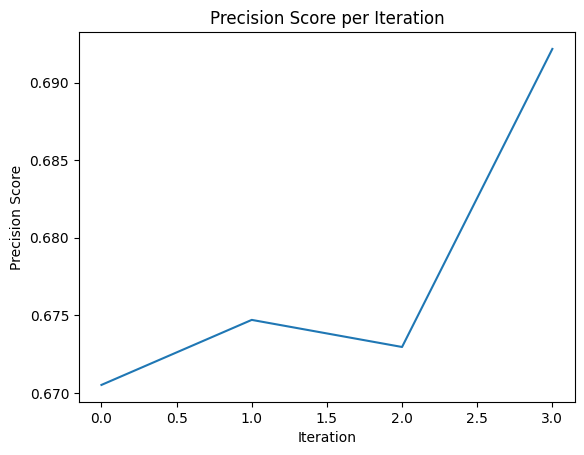

In [ ]:

plt.plot(score)
plt.xlabel('Iteration')
plt.ylabel('Precision Score')
plt.title('Precision Score per Iteration')
plt.show()

In [ ]:
preprocessor = StandardScaler()
# preprocessor = MinMaxScaler()
reductor = PCA(n_components=2)
algo = KNeighborsClassifier(n_neighbors=49)


# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reductor', reductor),
    ('algo', algo)
])

X_train, X_test, y_train, y_test = train_test_split(X, df_encoded['is_recid'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_tot = pipeline.predict(X)

cluster_series = pd.Series(y_pred_tot, index=X.index)

data['prediction'] = cluster_series
print(confusion_matrix(df_encoded['is_recid'], y_pred_tot))
data.to_csv("data/prediction_with_knn.csv")

              precision    recall  f1-score   support

         0.0       0.68      0.73      0.70      1585
         1.0       0.63      0.57      0.60      1277

    accuracy                           0.66      2862
   macro avg       0.65      0.65      0.65      2862
weighted avg       0.65      0.66      0.65      2862

[[5835 2029]
 [2616 3827]]
